In [1]:
from aide_predict import *
import pandas as pd
import numpy as np
from aide_predict.utils.plotting import *
get_supported_tools()

/kfs2/projects/proteinml/repos/aide_predict/aide_predict/patches_.py:7: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'str'):
/projects/proteinml/.links/miniconda3/envs/aidep/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


HMMWrapper: AVAILABLE
ESM2LikelihoodWrapper: AVAILABLE
MSATransformerLikelihoodWrapper: AVAILABLE
EVMutationWrapper: AVAILABLE
SaProtLikelihoodWrapper: AVAILABLE
VESPAWrapper: AVAILABLE
EVEWrapper: EVE requires EVE_CONDA_ENV and EVE_REPO environment variables to be set
SSEmbWrapper: SSEmb requires SSEMB_CONDA_ENV and SSEMB_REPO environment variables to be set
ESM2Embedding: AVAILABLE
OneHotAlignedEmbedding: AVAILABLE
OneHotProteinEmbedding: AVAILABLE
MSATransformerEmbedding: AVAILABLE
SaProtEmbedding: AVAILABLE
KmerEmbedding: AVAILABLE



'HMMWrapper: AVAILABLE\nESM2LikelihoodWrapper: AVAILABLE\nMSATransformerLikelihoodWrapper: AVAILABLE\nEVMutationWrapper: AVAILABLE\nSaProtLikelihoodWrapper: AVAILABLE\nVESPAWrapper: AVAILABLE\nEVEWrapper: EVE requires EVE_CONDA_ENV and EVE_REPO environment variables to be set\nSSEmbWrapper: SSEmb requires SSEMB_CONDA_ENV and SSEMB_REPO environment variables to be set\nESM2Embedding: AVAILABLE\nOneHotAlignedEmbedding: AVAILABLE\nOneHotProteinEmbedding: AVAILABLE\nMSATransformerEmbedding: AVAILABLE\nSaProtEmbedding: AVAILABLE\nKmerEmbedding: AVAILABLE\n'

In [2]:
import requests
import io
import zipfile
def load_zip_file_to_dataframe(url, zip_file_name, csv_file_name):
    # Download the zip file
    response = requests.get(url)
    zip_file = io.BytesIO(response.content)

    # Open the zip file
    with zipfile.ZipFile(zip_file) as z:
        # Read the CSV file inside the zip
        with z.open(csv_file_name) as f:
            # Load the CSV into a pandas DataFrame
            df = pd.read_csv(f)
    
    return df

## Example 1: Zero shot in silico mutagenesis

[SaProt](https://github.com/westlake-repl/SaProt) is the top performing ZS predictor on the [ProteinGym](https://proteingym.org/benchmarks) benchmark as of 08.24, it leverages structure context.

In [3]:
# load the wild type protein
wt = ProteinSequence.from_pdb("ENVZ_ECOLI.pdb")
# Create a SSM library
library = wt.saturation_mutagenesis()
library

ProteinSequences(count=1140)

In [4]:
# Initialize and "fit" the model (it is pretrained so we needn't pass anything)
model = SaProtLikelihoodWrapper(
    device="cuda:1",
    marginal_method="wildtype_marginal",
    wt=wt
)
model.fit([])

SaProtLikelihoodWrapper(device='cuda:1', marginal_method='wildtype_marginal',
                        use_cache=True,
                        wt=ProteinSequence(id='ENVZ_ECOLI', seq='LADDRTLLMAGVSHDLRTPL...'))

In [5]:
scores = model.predict(library)

Some weights of EsmForMaskedLM were not initialized from the model checkpoint at westlake-repl/SaProt_650M_AF2 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight', 'esm.embeddings.position_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing log likelihoods: 100%|██████████| 1/1 [00:03<00:00,  3.37s/sequence]


/kfs2/projects/proteinml/repos/aide_predict/aide_predict/utils/plotting.py:92: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_matrix = full_matrix.fillna(-999)


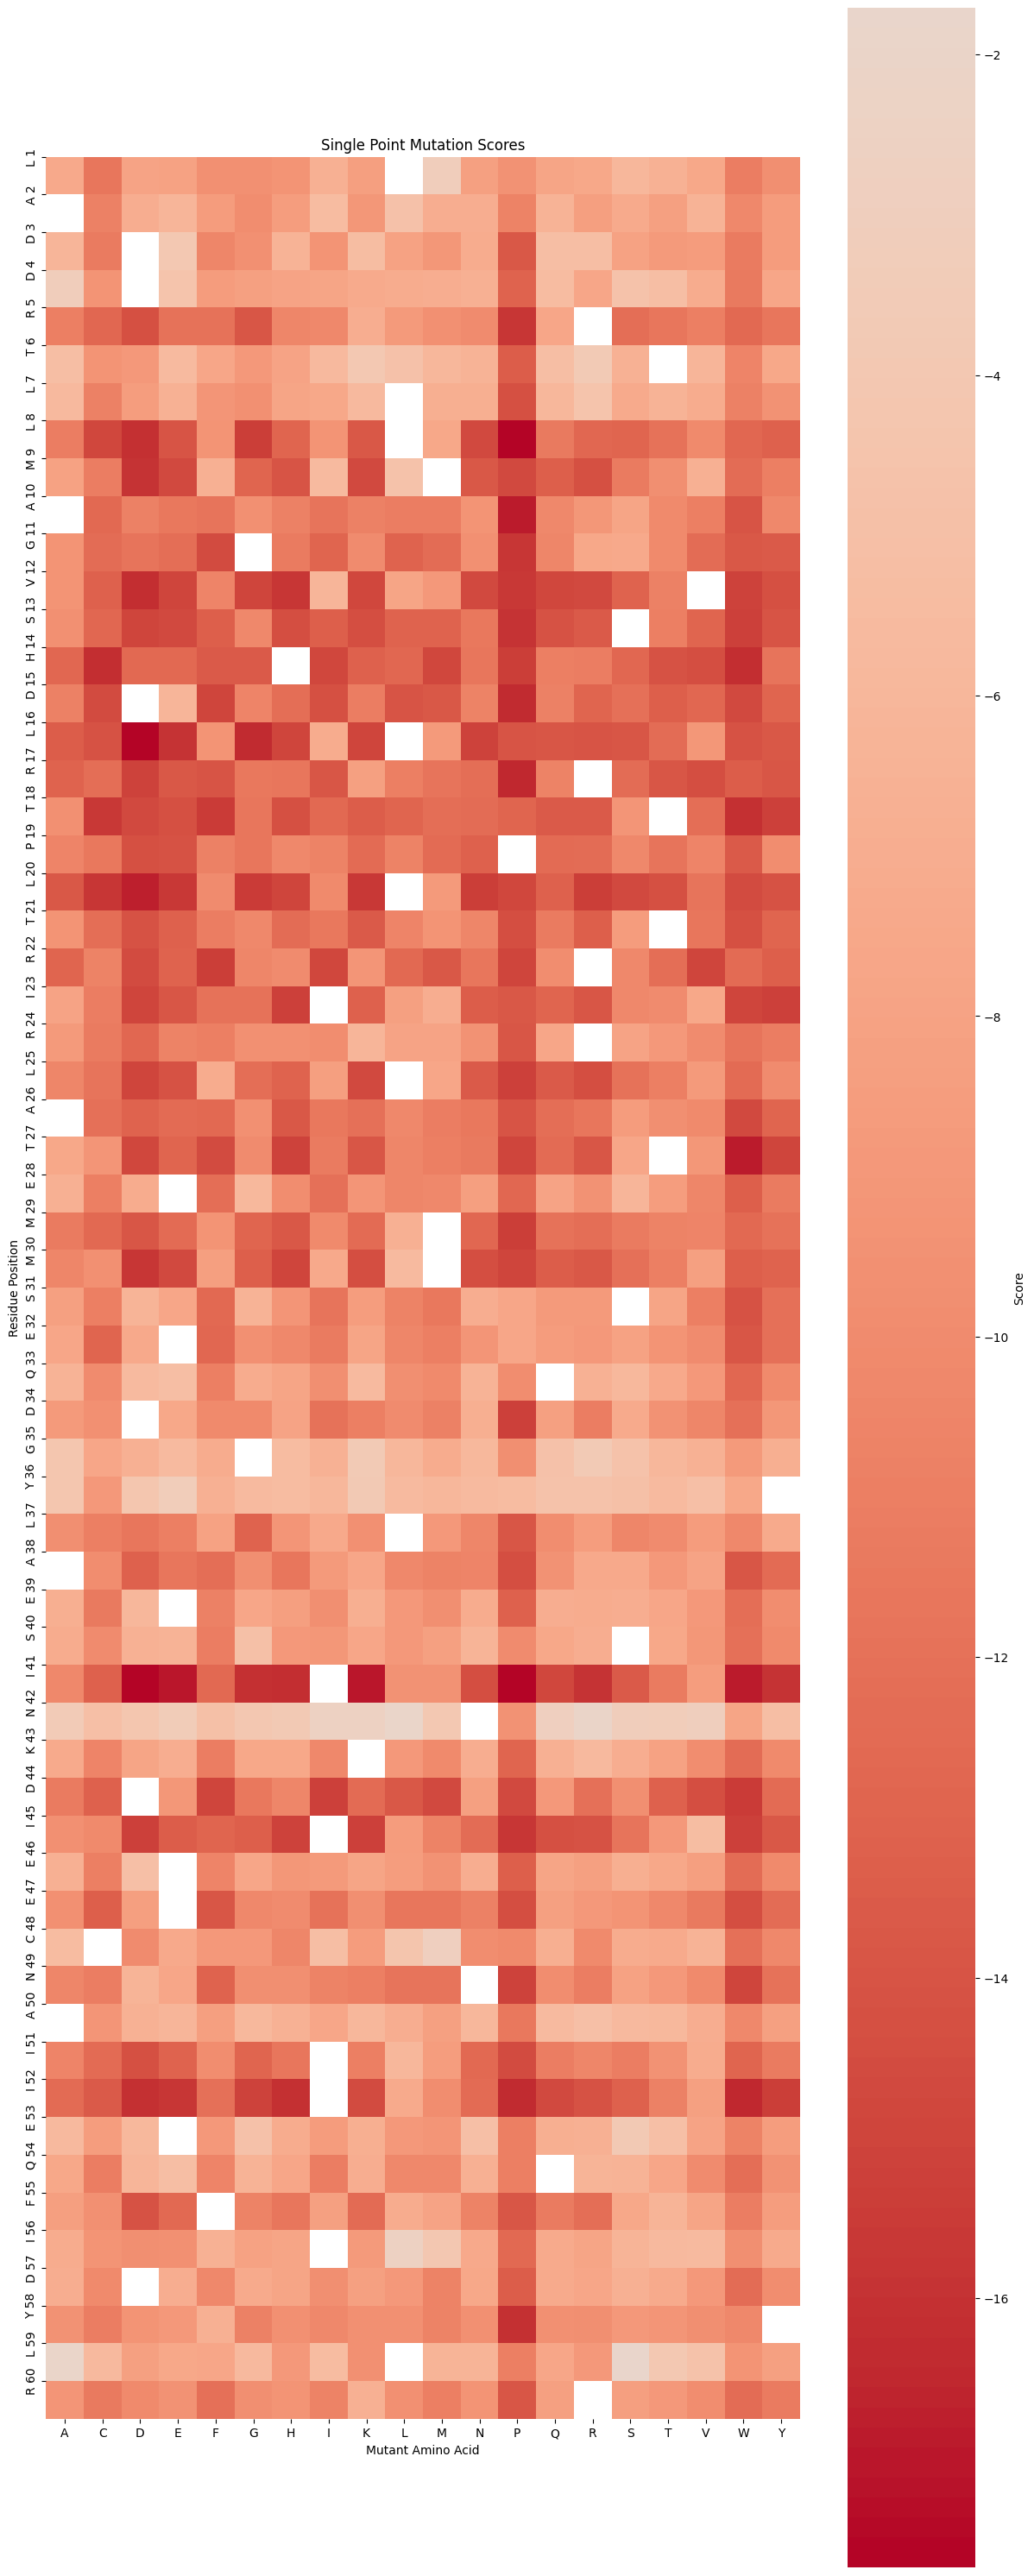

In [6]:
plot_mutation_heatmap(library.ids, scores.flatten())

## Example 2: Compare ZS predictors

Repeat of the example above, but compare multiple methods. Also, the CSV with experimental data has sequences in it so no need to create our own library.
1. SaProt, whoch conditions on structure context
2. ESM2, which conditions on only
3. EVMutation, which uses pairwise energy couplings from an MSA
4. MSATransformer, which uses uses an MSA to condition on sequence and evolutionary context

In [8]:
# load the structure for SaProt
wt = ProteinSequence.from_pdb("ENVZ_ECOLI.pdb")

# load an MSA
msa = ProteinSequences.from_fasta("ENVZ_ECOLI_extreme_filtered.a2m")
# process the MSA/compute weights
msa_processed = msa.msa_process(focus_seq_id=msa[0].id)

# make sure that the wild type sequence is the same in the MSA and the structure
assert str(wt.with_no_gaps().upper()) == str(msa_processed[0].with_no_gaps().upper())
wt.id = msa_processed[0].id
wt.msa = msa_processed

# get the library to evaluate
X, y = ProteinSequences.from_csv("ENVZ_ECOLI_Ghose_2023.csv", seq_col="mutated_sequence", id_col='mutant', label_cols='DMS_score')

/kfs2/projects/proteinml/repos/aide_predict/aide_predict/bespoke_models/embedders/ohe.py:275: UserWarning: Input sequences are already aligned. Using them as-is for encoding.
  warnings.warn("Input sequences are already aligned. Using them as-is for encoding.")


In [12]:
models = {
    'SaProt': SaProtLikelihoodWrapper(device="cuda:1", marginal_method="wildtype_marginal", wt=wt).fit(),
    'EVMutation': EVMutationWrapper(wt=wt,).fit(),
    'ESM2': ESM2LikelihoodWrapper(device="cuda:1", marginal_method="wildtype_marginal", wt=wt).fit(),
    'MSATransformer': MSATransformerLikelihoodWrapper(device="cuda:1", marginal_method="wildtype_marginal", wt=wt).fit(),     
}

In [13]:
scores = {}
for name, model in models.items():
    model.fit(msa_processed)
    scores[name] = model.score(X, y)

/kfs2/projects/proteinml/repos/aide_predict/aide_predict/bespoke_models/base.py:388: UserWarning: This model expects no fit, but received input. Ignoring input: ProteinSequences(count=2472)
  warnings.warn(f"This model expects no fit, but received input. Ignoring input: {X}")
Some weights of EsmForMaskedLM were not initialized from the model checkpoint at westlake-repl/SaProt_650M_AF2 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight', 'esm.embeddings.position_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing log likelihoods: 100%|██████████| 1/1 [00:00<00:00,  8.29sequence/s]
Model is already fitted. Skipping
  0%|          | 1/1121 [00:00<04:57,  3.76it/s]/kfs2/projects/proteinml/repos/aide_predict/aide_predict/bespoke_models/predictors/evmutation.py:186: UserWarning: Mutation A2C is not supported by EVCouplings statistics and will be ignored fo

In [14]:
scores

{'SaProt': 0.16823468527205648,
 'EVMutation': 0.21139952990686237,
 'ESM2': 0.18994435108932253,
 'MSATransformer': 0.19305613309263833}

## Example 3: Construct a supervised global predictor using PLM embeddings
Use [Meltome atlas](https://www.nature.com/articles/s41592-020-0801-4) dataset to create a model for predicting protein melting temperature given a protein sequence.
Here a __very small__ sample was extracted from [FLIP](https://github.com/J-SNACKKB/FLIP/blob/main/splits/meltome/splits.zip).

This should look very similar to a typical supervised learning pipeline you'd see on a Medium article.

NOTE: Disregard the poor score. We are sampling down the data significantly for demonstration purposes.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

In [6]:
exp = load_zip_file_to_dataframe("https://github.com/J-SNACKKB/FLIP/raw/main/splits/meltome/splits.zip", "splits", "splits/mixed_split.csv").sample(n=3000)
# drop long sequences
exp = exp[exp['sequence'].str.len() <= 300]

seqs, y = ProteinSequences.from_df(exp, seq_col="sequence", label_cols="target")

In [7]:
#split data
seqs_train, seqs_test, y_train, y_test = train_test_split(seqs, y, test_size=0.2, random_state=42)
# initialize the classes - one is a aide_predict sublcass, the predictor is a sklearn regressor.
# same api.
embedder = ESM2Embedding(device='cuda:1', flatten=True, pool='mean', batch_size=2)
regressor = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# fit the models
embedder.fit(seqs_train, y_train)
X_train = embedder.transform(seqs_train)
regressor.fit(X_train, y_train)

/kfs2/projects/proteinml/repos/aide_predict/aide_predict/bespoke_models/base.py:388: UserWarning: This model expects no fit, but received input. Ignoring input: [ProteinSequence(id='215', seq='MSMHKALTIAGSDSSGGAGI...'), ProteinSequence(id='294', seq='MKGLFVESSIFSKNRADYLS...'), ProteinSequence(id='49', seq='MAEGAARLSLVVALLVLGLK...'), ProteinSequence(id='720', seq='MVLKVYVSGMSGNKEVKKRQ...'), ProteinSequence(id='235', seq='MEQSVANLVDMRDVSFTRGN...'), ProteinSequence(id='801', seq='MKKKRRLFIRTGILLVLICA...'), ProteinSequence(id='966', seq='MLQGSIVFILVVTGLICVVG...'), ProteinSequence(id='895', seq='MVLKVYGPHFASPKRALVTL...'), ProteinSequence(id='532', seq='MVDSKKRPGKDLDRIDRNIL...'), ProteinSequence(id='334', seq='MDDSETGFNLKVVLVSFKQC...'), ProteinSequence(id='985', seq='MNNIAPQSPVMRRLTLQDNP...'), ProteinSequence(id='259', seq='MEEKQILCVGLVVLDVISLV...'), ProteinSequence(id='685', seq='MEPPNLYPVKLYVYDLSKGL...'), ProteinSequence(id='33', seq='MGARASQEPRTRVRAGLRVL...'), ProteinSequence(id='31', seq

MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)

In [10]:
X_test = embedder.transform(seqs_test)
print("Model score:", regressor.score(X_test, y_test))

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing ESM2 embeddings: 100%|██████████| 199/199 [00:02<00:00, 93.55it/s]


Model score: 0.24747488043319388


## Example 4: Combine components to create a ZS + Supervised combinatorial predictor as an `sklearn.Pipeline`
[Hsu et al.](https://www.nature.com/articles/s41587-021-01146-5) suggested that giving ZS scores to a supervised model improves performance. Here we can combine components like they did in an easy to read a reproduce sklearn pipeline. 

We use a very small sample of the GB1 dataset for this example extracted from [FLIP](https://github.com/J-SNACKKB/FLIP/blob/main/splits/gb1/splits.zip).

To illustrate the flexibility, we use ESM2 as a ZS predictor, one hot the sequences, and also embed the sequences using ESM2 __pooling over only the positions that change in the GB1 landscape__.

In [11]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

In [12]:
# load the experimental data and split it
exp = load_zip_file_to_dataframe("https://github.com/J-SNACKKB/FLIP/raw/main/splits/gb1/splits.zip", "splits", "splits/sampled.csv")
seqs, y = ProteinSequences.from_df(exp, seq_col="sequence", label_cols="target")

#split data
seqs_train, seqs_test, y_train, y_test = train_test_split(seqs, y, test_size=0.2, random_state=42)

In [13]:
# prepare the zs predictor
wt = ProteinSequence("MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTELEVLFQGPLDPNSMATYEVLCEVARKLGTDDREVVLFLLNVFIPQPTLAQLIGALRALKEEGRLTFPLLAECLFRAGRRDLLRDLLHLDPRFLERHLAGTMSYFSPYQLTVLHVDGELCARDIRSLIFLSKDTIGSRSTPQTFLHWVYCMENLDLLGPTDVDALMSMLRSLSRVDLQRQVQTLMGLHLSGPSHSQHYRHTPLEHHHHHH", id='WT')
esm2like = ESM2LikelihoodWrapper(device="cuda:1", marginal_method="wildtype_marginal", wt=wt)
esm2like.fit()

ESM2LikelihoodWrapper(device='cuda:1', marginal_method='wildtype_marginal',
                      wt=ProteinSequence(id='WT', seq='MQYKLILNGKTLKGETTTEA...'))

In [14]:
# get the variable positions
variable_positions = seqs.mutated_positions
variable_positions

[38, 39, 40, 53]

In [15]:
# build the pipeline
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('esm2', ESM2Embedding(device='cuda:1', flatten=True, pool=None, batch_size=2, positions=variable_positions)),
        ('esm2like', esm2like),
        ('ohe', OneHotProteinEmbedding())
    ])),
    ('selector', VarianceThreshold()),
    ('scaler', MinMaxScaler()),
    ('regressor', MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42))
])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
pipeline.fit(seqs_train, y_train)

/kfs2/projects/proteinml/repos/aide_predict/aide_predict/bespoke_models/base.py:388: UserWarning: This model expects no fit, but received input. Ignoring input: [ProteinSequence(id='1739', seq='MQYKLILNGKTLKGETTTEA...'), ProteinSequence(id='4057', seq='MQYKLILNGKTLKGETTTEA...'), ProteinSequence(id='8219', seq='MQYKLILNGKTLKGETTTEA...'), ProteinSequence(id='1650', seq='MQYKLILNGKTLKGETTTEA...'), ProteinSequence(id='73', seq='MQYKLILNGKTLKGETTTEA...'), ProteinSequence(id='8477', seq='MQYKLILNGKTLKGETTTEA...'), ProteinSequence(id='3204', seq='MQYKLILNGKTLKGETTTEA...'), ProteinSequence(id='2223', seq='MQYKLILNGKTLKGETTTEA...'), ProteinSequence(id='5484', seq='MQYKLILNGKTLKGETTTEA...'), ProteinSequence(id='7524', seq='MQYKLILNGKTLKGETTTEA...'), ProteinSequence(id='7621', seq='MQYKLILNGKTLKGETTTEA...'), ProteinSequence(id='6152', seq='MQYKLILNGKTLKGETTTEA...'), ProteinSequence(id='8280', seq='MQYKLILNGKTLKGETTTEA...'), ProteinSequence(id='6545', seq='MQYKLILNGKTLKGETTTEA...'), ProteinSequenc

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('esm2',
                                                 ESM2Embedding(batch_size=2,
                                                               device='cuda:1',
                                                               flatten=True,
                                                               positions=[38,
                                                                          39,
                                                                          40,
                                                                          53],
                                                               use_cache=True)),
                                                ('esm2like',
                                                 ESM2LikelihoodWrapper(device='cuda:1',
                                                                       marginal_method='wildtype_marginal',
                                                                       wt=ProteinSequence(id='WT', seq='MQYKLILNGKTLKGETTTEA...'))),
                                                ('ohe',
                                                 OneHotProteinEmbedding())])),
                ('selector', VarianceThreshold()), ('scaler', MinMaxScaler()),
                ('regressor',
                 MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000,
                              random_state=42))])

In [17]:
score = pipeline.score(seqs_test, y_test)
print("Model score:", score)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing log likelihoods: 100%|██████████| 1/1 [00:00<00:00, 143.69sequence/s]


Model score: 0.9278542753073704


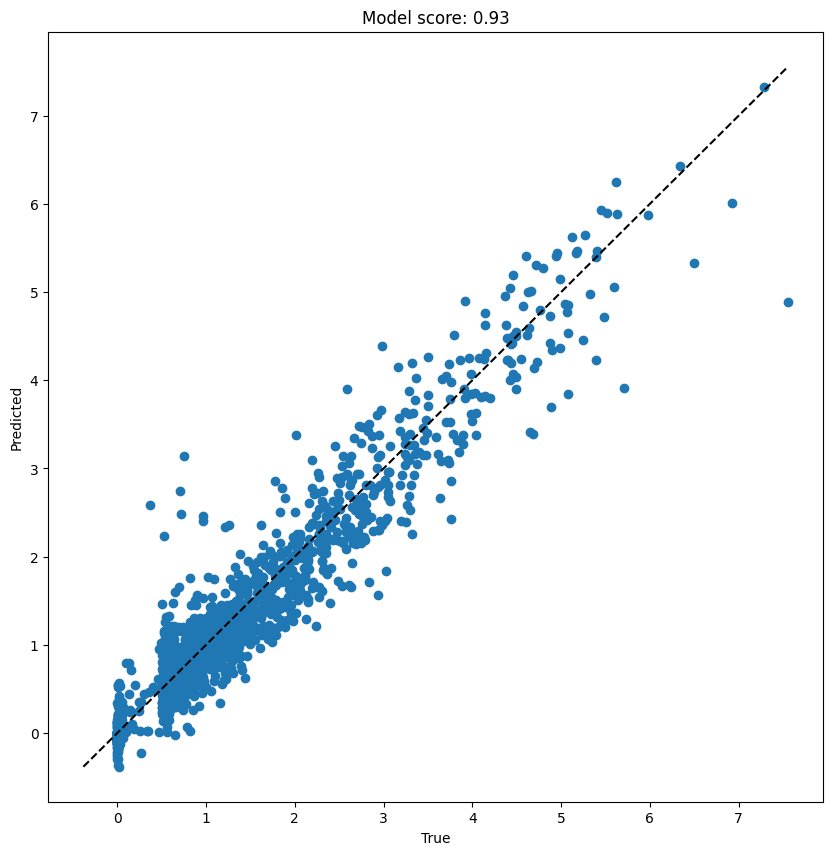

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
min_min = min(y_test.min(), pipeline.predict(seqs_test).min())
max_max = max(y_test.max(), pipeline.predict(seqs_test).max())
ax.plot([min_min, max_max], [min_min, max_max], 'k--')
ax.scatter(y_test, pipeline.predict(seqs_test))
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
ax.set_title(f"Model score: {score:.2f}")
plt.show()

## Example 5: Figuring out what model are available given the data you have

In addition to `get_available_models` which shows which modules are installed and accessible, we provide `check_model_compatibility` which will tell you which Protein modules you can use given your dataset.

Using a previous example, let's say you have only a WT sequence with known structure and some combinatorial data - No MSA.

In [3]:
seqs = ProteinSequences.from_csv("ENVZ_ECOLI_Ghose_2023.csv", seq_col="mutated_sequence", id_col='mutant')
wt = ProteinSequence.from_pdb("ENVZ_ECOLI.pdb")
check_model_compatibility(
    training_sequences=seqs,
    wt=wt,
)

{'compatible': ['ESM2Embedding',
  'ESM2LikelihoodWrapper',
  'HMMWrapper',
  'KmerEmbedding',
  'OneHotAlignedEmbedding',
  'OneHotProteinEmbedding',
  'SaProtEmbedding',
  'SaProtLikelihoodWrapper',
  'VESPAWrapper'],
 'incompatible': ['EVEWrapper',
  'EVMutationWrapper',
  'MSATransformerEmbedding',
  'MSATransformerLikelihoodWrapper',
  'SSEmbWrapper']}

Or maybe you have only a set of wt proteins (variable length) and some experimental data assigned to them. Notice how we cannot use OneHot because the sequences are variable length and not aligned.

In [4]:
df = load_zip_file_to_dataframe("https://github.com/J-SNACKKB/FLIP/raw/main/splits/meltome/splits.zip", "splits", "splits/mixed_split.csv").sample(n=3000)
seqs, y = ProteinSequences.from_df(df, seq_col="sequence", label_cols="target")

In [5]:
check_model_compatibility(
    training_sequences=seqs,
    wt=None 
)

{'compatible': ['ESM2Embedding', 'KmerEmbedding'],
 'incompatible': ['ESM2LikelihoodWrapper',
  'EVEWrapper',
  'EVMutationWrapper',
  'HMMWrapper',
  'MSATransformerEmbedding',
  'MSATransformerLikelihoodWrapper',
  'OneHotAlignedEmbedding',
  'OneHotProteinEmbedding',
  'SSEmbWrapper',
  'SaProtEmbedding',
  'SaProtLikelihoodWrapper',
  'VESPAWrapper']}

## Example 6: Writing a new embedder class

Creating a simple embedder class that is a kmer prepresentation of foldseek tokens.

In [ ]:
import numpy as np
from typing import List, Union, Optional
from collections import defaultdict

from aide_predict.bespoke_models.base import ProteinModelWrapper, CanHandleAlignedSequencesMixin, RequiresStructureMixin
from aide_predict.utils.data_structures import ProteinSequences, ProteinSequence
from aide_predict.utils.common import MessageBool
from aide_predict.bespoke_models.predictors.saprot import get_structure_tokens
AVAILABLE = MessageBool(True, "Available")

class FoldseekKmerEmbedding(RequiresStructureMixin, CanHandleAlignedSequencesMixin, ProteinModelWrapper):
    _available=AVAILABLE
    def __init__(self, metadata_folder: str = None, 
                 k: int = 3, 
                 wt: ProteinSequence = None):
        super().__init__(metadata_folder=metadata_folder, wt=None)
        self.k = k
        self._kmer_to_index = {}

    def _fit(self, X: ProteinSequences, y: Optional[np.ndarray] = None) -> 'KmerEmbedding':
        unique_kmers = set()
        for seq in X:
            if seq.structure is None:
                raise ValueError("KmerEmbedding requires a structure to be present in each sequence.")

            struct_str = get_structure_tokens(seq.structure)
            unique_kmers.update(struct_str[i:i+self.k] for i in range(len(struct_str) - self.k + 1))
        
        self._kmer_to_index = {kmer: i for i, kmer in enumerate(sorted(unique_kmers))}
        self.n_features_ = len(self._kmer_to_index)
        self.fitted_ = True
        return self

    def _transform(self, X: ProteinSequences) -> np.ndarray:
        """
        Transform the protein sequences into K-mer embeddings.

        Args:
            X (ProteinSequences): The input protein sequences.

        Returns:
            np.ndarray: The K-mer embeddings for the sequences.
        """
        embeddings = np.zeros((len(X), self.n_features_), dtype=np.float32)

        for i, seq in enumerate(X):
            if seq.structure is None:
                raise ValueError("KmerEmbedding requires a structure to be present in each sequence.")
            
            struct_str = get_structure_tokens(seq.structure)
            for j in range(len(struct_str) - self.k + 1):
                kmer = struct_str[j:j+self.k]
                if kmer in self._kmer_to_index:
                    embeddings[i, self._kmer_to_index[kmer]] += 1

        return embeddings

## Example 6: Writing a new ZS predictor class that requires a unique environment

In order to avoid dependancy weight, if a particular model requires a very heavy/unique environment, or a bespoke script that is uninstallable on some repo, the recommended way is to have to have it called as a subprocess in its own environment. You can still mixin in order to make the available data as clean and ready to apss to the scripr as possible. eg. if the method requires structure and fixed length sequences:

```python
import numpy as np
from typing import List, Union, Optional
from collections import defaultdict
import os
import subprocess
import tempfile
from aide_predict.bespoke_models.base import ProteinModelWrapper, RequiresStructureMixin, RequiresFixedLengthSequencesMixin
from aide_predict.utils.data_structures import ProteinSequences, ProteinSequence
from aide_predict.utils.common import MessageBool
from aide_predict.bespoke_models.predictors.saprot import get_structure_tokens

try:
    ENV_NAME = os.environ['BESPOKE_ENV_NAME']
    MODEL_BASE_DIR = os.environ['BESPOKE_MODEL_BASE_DIR']
    AVAILABLE = MessageBool(True, 'Model is available')
except KeyError:
    AVAILABLE = MessageBool(False, 'Model is not available, please install and set environment variables.')

class MyBespokeModel(ProteinModelWrapper, RequiresStructureMixin, RequiresFixedLengthSequencesMixin):
    _available = AVAILABLE

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # set params....

    def _fit(self, X: ProteinSequences, y: Optional[np.ndarray] = None):
        # prepare data
        # call subprocess
        input_fasta = tempfile.NamedTemporaryFile(delete=False)
        X.to_fasta(input_fasta.name)
        # temdir for structures
        with tempfile.TemporaryDirectory() as tempdir:
            # pass structure files to the script
            structure_files = open(os.path.join(tempdir, 'structure_files.txt'), 'w')
            for seq in X:
                struct_path = seq.structure.pdb_file
                structure_files.write(f'{seq.id}\t{struct_path}\n')
            structure_files.close()

            # call subprocess in the environment and base dir
            subprocess.run(['python', 'path/to/train_script.py', '-s', structure_files, input_fasta.name, '-o', os.path.join(self.metadata_folder, 'model.pkl'), env=ENV_NAME, cwd=MODEL_BASE_DIR])
        return self

    def _transform(self, X: ProteinSequences) -> np.ndarray:
        # something similar to fit, call a predict script etc...

        return outputs.
    